# Part 6 - Reinforcement Learning

- reward and punishment algorithms


## The Multi-armed Bandit Problem

- We have $d$ arms. For example, arms are ads that we display to users each time they connect to a web page.
- Each time a user connects to this web page, that makes a round.
- At each round $n$, we choose one ad to display to the user.
- At each round $n$, ad $i$ gives reward $r_i(n)\in {0,1}: r_i(n)=1\text{ if the user clicked on the ad, 0 if the user didn't}$
- Our goal is to maximize the total reward we get over many rounds


## Upper Confidence Bound
__Step 1__: At each round $n$, we consider two numbers for each ad $i$:

- $N_i(n)$, the number of times the ad i was selected up to round $n$;
    
- $R_i(n)$, the sum of rewards of the ad i up to round $n$.
        
__Step 2__: From these two numbers we compute:

- the average reward of ad $i$ up to round $n$
        
$$ \bar{r}_i(n) = \frac{R_i(n)}{N_i(n)} $$
        
- the confidence interval $[\bar{r}_i(n)-\Delta_i(n), \bar{r}_i(n)+\Delta_i(n)]$ at round $n$ with
        
$$ \Delta_i(n) = \sqrt{\frac{3 log(n)}{2N_i(n)}} $$
        
__Step 3__: We select the ad $i$ that hs the maximum UCB $\bar{r}_i(n)+\Delta_i(n)$

In [1]:
# import the libraries that will be used
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import random
import math

In [2]:
# import dataset
dir1 = '/Users/esousa/transfered/Classes/udemy_machineLearning_A-Z/Part6_Reinforcement_Learning/'
dataset = pd.read_csv(dir1+'Ads_CTR_Optimisation.csv')
dataset.describe()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,0.170300,0.129500,0.072800,0.119600,0.269500,0.012600,0.111200,0.209100,0.095200,0.04890
std,0.375915,0.335769,0.259821,0.324509,0.443722,0.111546,0.314395,0.406686,0.293506,0.21567
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [5]:
# Random Selection Algorithm

N = 10000
d = 10
ads_selected = []
total_reward = 0
for n in range(0, N):
    ad = random.randrange(d)
    ads_selected.append(ad)
    reward1 = dataset.values[n,ad]
    total_reward = total_reward+reward1

Text(0, 0.5, 'Number of times each ad was selected')

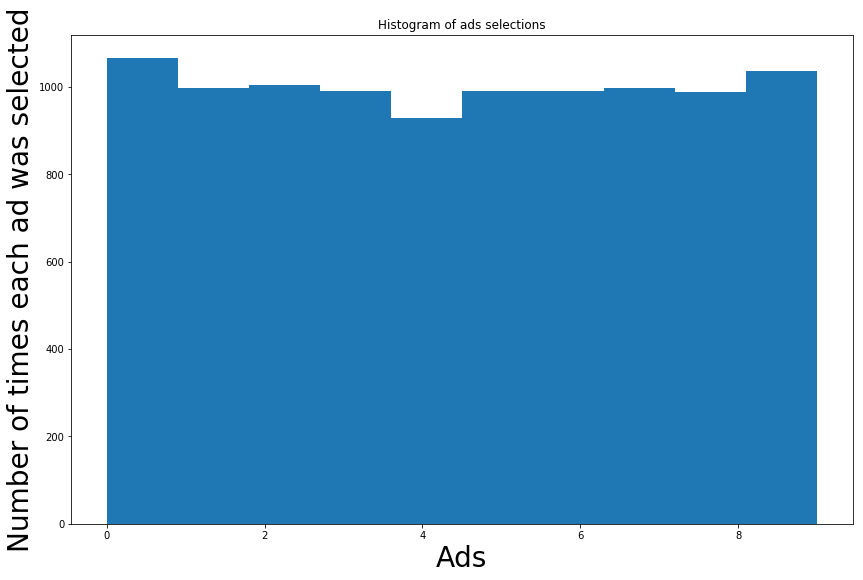

In [6]:
# Visualizing the results - Histogram
plt.figure(figsize=(14,9))
plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads',fontsize=28)
plt.ylabel('Number of times each ad was selected',fontsize=28)

In [7]:
print(total_reward)

1229


In [8]:
# UCB Algorithm
N = 10000
d = 10
ads_selected = []
numbers_of_selections = [0] * d
sums_of_rewards = [0.] * d
total_reward = 0

for n in range(0, N):
    ad = 0
    max_upper_bound = 0.
    
    for i in range(0, d):
        if (numbers_of_selections[i] > 0):
            average_reward = sums_of_rewards[i] / numbers_of_selections[i]
            delta_i = math.sqrt(3/2 * math.log(n + 1) / numbers_of_selections[i])
            upper_bound = average_reward + delta_i
        else:
            upper_bound = 1e400
            
        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            ad = i
            
    ads_selected.append(ad)
    numbers_of_selections[ad] = numbers_of_selections[ad] + 1
    reward = dataset.values[n, ad]
    sums_of_rewards[ad] = sums_of_rewards[ad] + reward
    total_reward = total_reward + reward

Text(0, 0.5, 'Number of times each ad was selected')

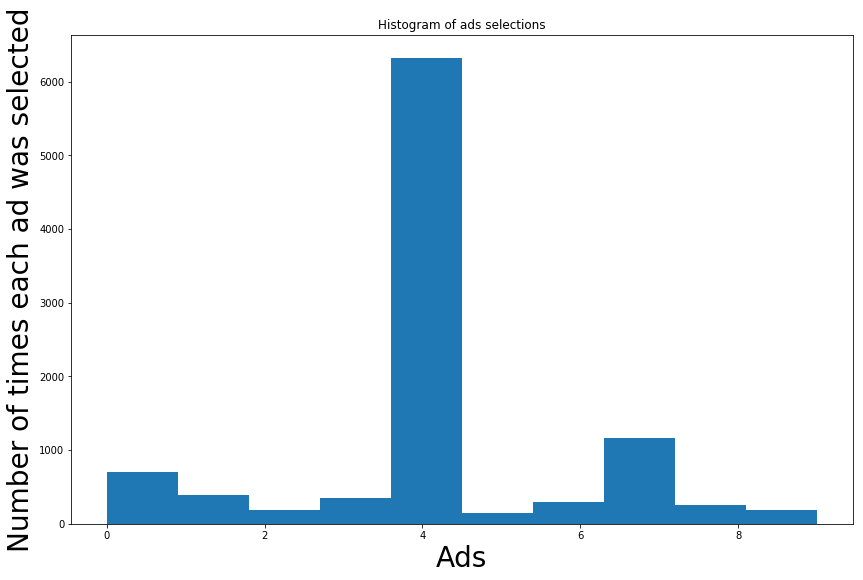

In [9]:
# Visualizing the results - Histogram
plt.figure(figsize=(14,9))
plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads', fontsize=28)
plt.ylabel('Number of times each ad was selected', fontsize=28)

In [10]:
print(total_reward)

2178


## Thompson Sampling

### Baysian Inference
* Ad $i$ get rewuards $y$ from Bernoulli distribution $p(y|\theta_i)\sim \mathcal{B}(\theta_i)$

* $\theta_i$ is unknown but we set its uncertainty by assuming it has a uniform distribution $p(\theta_i)\sim\mathcal{U}([0,1])$, which is the prior distribution

* Bayes Rule: we approach $\theta_i$ by the posterior distribution
$$ p(\theta_i|y) = \frac{p(y|\theta_i)p(\theta_i)}{\int p(y|\theta_i)p(\theta_i) d\theta_i} \propto p(\theta_i|y)\times p(\theta_i)$$

* We get $p(\theta_i)\sim \beta(\text{number of successes +1, number of failures +1})$

* At each round $n$ we take a random draw $\theta_i(n)$ from this posterior distribution $p(\theta_i|y)$, for each ad $i$

* At each round $n$ we select the ad $i$ that has the highest $\theta_i(n)$

### Thompson Sampling Algorithm

__Step 1__: At each round $n$, we consider two numbers for each ad $i$:
* $N_i^1(n)$: the number of times the ad $i$ got reward 1 up to round $n$,
* $N_i^0(n)$: the number of times the ad i got reward 0 up to round $n$.

__Step 2__: From each ad $i$, we take a random draw from the distribution below:
$$ \theta_i(n) = \beta(N_i^1(n)+1, N_i^0(n)+1) $$

__Step 3__: We select the ad that has the highest $\theta_i(n)$

In [11]:
# Thompson Sampling algorithm
N = 10000
d = 10
ads_selected = []
numbers_of_rewards_1 = [0] * d
numbers_of_rewards_0 = [0] * d
total_reward = 0
for n in range(0, N):
    ad = 0
    max_random = 0
    for i in range(0, d):
        random_beta = random.betavariate(numbers_of_rewards_1[i] + 1, numbers_of_rewards_0[i] + 1)
        if random_beta > max_random:
            max_random = random_beta
            ad = i
    ads_selected.append(ad)
    reward = dataset.values[n, ad]
    if reward == 1:
        numbers_of_rewards_1[ad] = numbers_of_rewards_1[ad] + 1
    else:
        numbers_of_rewards_0[ad] = numbers_of_rewards_0[ad] + 1
    total_reward = total_reward + reward

Text(0, 0.5, 'Number of times each ad was selected')

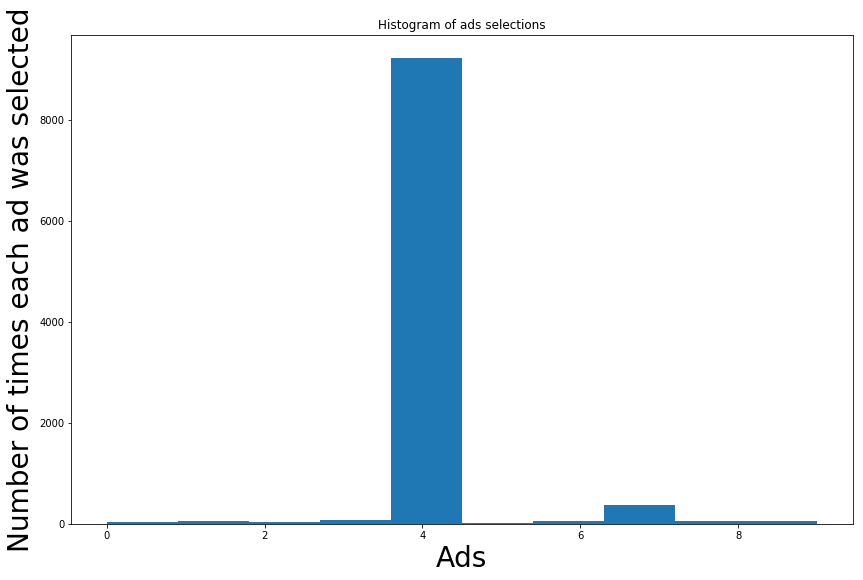

In [12]:
# Visualizing the results - Histogram
plt.figure(figsize=(14,9))
plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads', fontsize=28)
plt.ylabel('Number of times each ad was selected', fontsize=28)

In [13]:
print(total_reward)

2598


### UCB vs Thompson Sampling

__UCB__
* Deterministic
* Requires update at every round

__TS__
* Probabilistic
* Can accomodate delayed feedback
* Better empirical evidence